- Classification: probability distribution (confidence)
- Regression: Function approximation, single answer, no uncertainty

- MSE(Mean square error) related to MLE(maximum likelihood estimation)
- MSE : negative log-likelihood + cosntant

Error = Bias^2 + Varience + Irreducible error

Quantifying the uncertainty of a model

Heteroskedasticity: When a variability of target with respect is not constant

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def generate_batch(batch_size=32):
  x = np.random.random(batch_size)*10 - 5
  sd = 0.05 + 0.1 * (x + 5)
  y = np.cos(x) - 0.3 * x + np.random.randn(batch_size) * sd
  return x, y

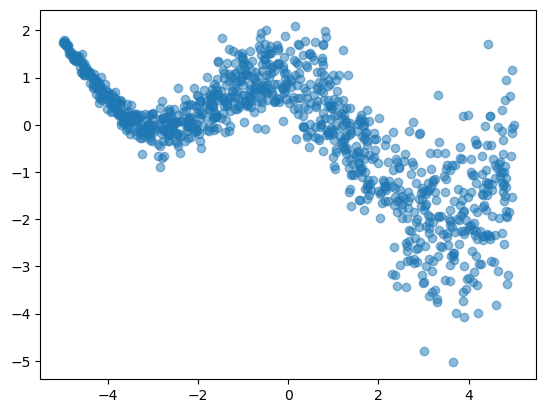

In [3]:
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5);

In [5]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.ann1 = nn.Sequential(
      nn.Linear(1, 10),
      nn.Tanh(),
      nn.Linear(10, 1),
    )
    self.ann2 = nn.Sequential(
      nn.Linear(1, 10),
      nn.Tanh(),
      nn.Linear(10, 1),
    )

  def forward(self, inputs):
    return self.ann1(inputs), self.ann2(inputs)
model = Model()

In [6]:
def criterion(outputs, targets):
  mu = outputs[0]
  v = torch.exp(outputs[1])

  # coefficient term
  c = torch.log(torch.sqrt(2 * np.pi * v))

  # exponent term
  f = 0.5 / v * (targets - mu)**2

  # mean log-likelihood
  nll = torch.mean(c + f)

  return nll

In [7]:
optimizer = torch.optim.Adam(model.parameters())


In [8]:
n_epochs = 5000
batch_size = 128
losses = np.zeros(n_epochs)
for i in range(n_epochs):
  x, y = generate_batch(batch_size)
  inputs = torch.from_numpy(x).float()
  targets = torch.from_numpy(y).float()
  inputs, targets = inputs.view(-1, 1), targets.view(-1, 1)
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, targets)
  losses[i] = loss.item()
  if i % 1000 == 0:
    print(i, losses[i])
  loss.backward()
  optimizer.step()

0 2.4521265029907227
1000 0.9548263549804688
2000 0.9301086068153381
3000 0.7618497610092163
4000 0.7074143290519714


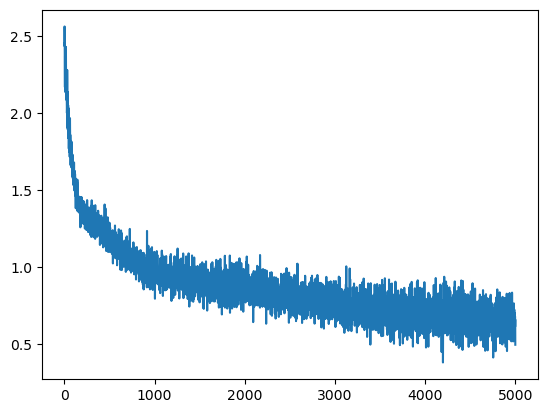

In [9]:
plt.plot(losses);


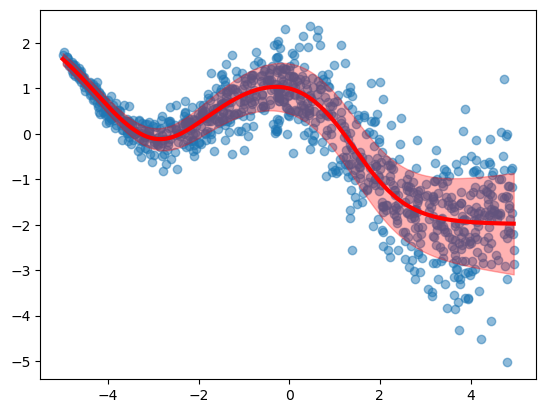

In [10]:
x, y = generate_batch(1024)
plt.scatter(x, y, alpha=0.5)
inputs = torch.from_numpy(x).float()
targets = torch.from_numpy(y).float()

inputs, targets = inputs.view(-1, 1), targets.view(-1, 1)

with torch.no_grad():
  outputs = model(inputs)
  yhat = outputs[0].numpy().flatten()
  sd = np.exp(outputs[1].numpy().flatten() / 2) # since encoded variance by default

idx = np.argsort(x)
plt.plot(x[idx], yhat[idx], linewidth=3, color='red')
plt.fill_between(x[idx], yhat[idx] - sd[idx], yhat[idx] + sd[idx], color='red', alpha=0.3)
plt.show()